# Import Packages

In [ ]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 29.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.6 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=e814ea44f94a77335de958c629a8fea05f0e1bd82cdc0e0f1a29b230957314c7
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [ ]:
import pretty_midi
import scipy.stats as stats
import pathlib
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc)
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

# Piano Mistake Generator

In [ ]:
class Difficulty(Enum):
    BEGINNER = "beginner"
    MEDIUM = "medium"
    ADVANCED = "advanced"


class ErrorType(Enum):
    WRONG_NOTE = "Wrong Note"
    MISSING_NOTE = "Missing Note"
    EXTRA_NOTE = "Extra Note"
    NO_ERROR = "No Error"


class PianoMistakeGenerator:
    def __init__(self, midi_file: str):
        """
        Initialize the mistake generator with a MIDI file.

        Args:
            midi_file (str): Path to the input MIDI file
        """
        try:
            self.midi = self._combine_instruments(midi_file)
            self.original_midi = copy.deepcopy(self.midi)
        except Exception as e:
            raise ValueError(f"Error loading MIDI file: {e}")

    def _combine_instruments(self, midi_file: str) -> pretty_midi.PrettyMIDI:
        """
        Combine all instruments into a single instrument

        Args:
            midi_file (str): Path to the MIDI file

        Returns:
            pretty_midi.PrettyMIDI: Combined MIDI data
        """
        midi = pretty_midi.PrettyMIDI(midi_file)
        combined_instrument = pretty_midi.Instrument(program=0)

        for instrument in midi.instruments:
            for note in instrument.notes:
                combined_instrument.notes.append(note)

        combined_midi = pretty_midi.PrettyMIDI()
        combined_midi.instruments.append(combined_instrument)
        return combined_midi

    def _extract_notes(self) -> List[Dict]:
        """Extract notes with temporal feature"""
        notes = []
        for instrument in self.midi.instruments:
            for note in instrument.notes:
                notes.append({
                    'pitch': note.pitch,
                    'start': note.start,
                    'end': note.end,
                    'velocity': note.velocity,
                    'duration': note.end - note.start
                })
        return sorted(notes, key=lambda x: x['start'])

    def _find_neighbor_pitch(self, pitch: int, forward: bool = True) -> int:
        """Find neighboring pitch in the scale"""
        scale_steps = [0, 2, 4, 5, 7, 9, 11]  # Major scale steps
        pitch_class = pitch % 12
        octave = pitch // 12

        current_step_idx = min(range(len(scale_steps)),
                               key=lambda i: abs(scale_steps[i] - pitch_class))

        if forward:
            next_step_idx = (current_step_idx + 1) % len(scale_steps)
            if next_step_idx == 0:
                octave += 1
        else:
            next_step_idx = (current_step_idx - 1) % len(scale_steps)
            if next_step_idx == len(scale_steps) - 1:
                octave -= 1

        return octave * 12 + scale_steps[next_step_idx]

    def _add_recording_delay(self, midi: pretty_midi.PrettyMIDI) -> pretty_midi.PrettyMIDI:
        """
        Simulate recording delay with realistic noise distribution.
        """
        modified = copy.deepcopy(midi)
        start_delay = np.random.normal(loc=0.05, scale=0.2, size=1)[0]
        start_delay = max(0.01, min(start_delay, 1.0))
        first_key_time = min(
            note.start for instrument in modified.instruments for note in instrument.notes)
        offset = start_delay - first_key_time

        for instrument in modified.instruments:
            for note in instrument.notes:
                note.start += offset
                note.end += offset
        end_delay = np.random.normal(loc=0.05, scale=0.2, size=1)[0]
        end_delay = max(0.01, min(end_delay, 1.0))
        modified._PrettyMIDI__end_time = modified.get_end_time() + end_delay
        return modified

    def _generate_mistake(self, midi: pretty_midi.PrettyMIDI, error_type: ErrorType, difficulty: Difficulty) -> pretty_midi.PrettyMIDI:
        """Generate mistakes"""
        modified = copy.deepcopy(midi)
        notes = modified.instruments[0].notes

        mistake_probabilities = {
            Difficulty.BEGINNER: 0.2,
            Difficulty.MEDIUM: 0.1,
            Difficulty.ADVANCED: 0.05
        }
        prob = mistake_probabilities[difficulty]

        if error_type == ErrorType.WRONG_NOTE:
            for note in notes:
                if random.random() < prob:
                    forward = random.choice([True, False])
                    note.pitch = self._find_neighbor_pitch(note.pitch, forward)

        elif error_type == ErrorType.MISSING_NOTE:
            modified.instruments[0].notes = [
                note for note in notes if random.random() >= prob
            ]

        elif error_type == ErrorType.EXTRA_NOTE:
            for note in notes:
                if random.random() < prob:
                    extra_note = copy.deepcopy(note)
                    extra_note.pitch += random.choice([-2, -1, 1, 2])
                    extra_note.start += random.uniform(-0.1, 0.1)
                    modified.instruments[0].notes.append(extra_note)

            modified.instruments[0].notes.sort(key=lambda n: n.start)

        return modified

    def generate_dataset(
        self,
        num_variations: int = 1000,
        difficulties: List[Difficulty] = None
    ) -> Tuple[List[pretty_midi.PrettyMIDI], List[str]]:
        """
        Generate a comprehensive dataset with nuanced mistake distribution.

        Args:
            num_variations (int): Total number of variations to generate
            difficulties (List[Difficulty]): Skill levels to include

        Returns:
            Tuple of generated MIDI files and their corresponding labels
        """
        if difficulties is None:
            difficulties = list(Difficulty)

        dataset = []
        labels = []

        distribution = {
            ErrorType.NO_ERROR: 0.25,
            ErrorType.WRONG_NOTE: 0.25,
            ErrorType.MISSING_NOTE: 0.25,
            ErrorType.EXTRA_NOTE: 0.25
        }

        # Generate samples for non-outlier error types
        for error_type, error_prob in distribution.items():
            samples_for_type = int(num_variations * error_prob)

            if error_type == ErrorType.NO_ERROR:
                # Generate clean samples
                for _ in range(samples_for_type):
                    clean_midi = self._add_recording_delay(
                        copy.deepcopy(self.midi))
                    dataset.append(clean_midi)
                    labels.append(ErrorType.NO_ERROR.value)
            else:
                # Generate single error and combined error samples
                single_samples = int(samples_for_type * 0.35)
                combined_samples = int(samples_for_type * 0.65)

                for is_combined in [False, True]:
                    target_samples = combined_samples if is_combined else single_samples

                    for _ in range(target_samples):
                        difficulty = random.choice(difficulties)

                        # Generate primary mistake
                        modified_midi = self._generate_mistake(
                            copy.deepcopy(self.midi),
                            error_type,
                            difficulty
                        )

                        # For combined errors, add another mistake type
                        if is_combined:
                            other_error_types = [
                                et for et in ErrorType
                                if et not in [ErrorType.NO_ERROR, error_type]
                            ]
                            secondary_error = random.choice(other_error_types)
                            modified_midi = self._generate_mistake(
                                modified_midi,
                                secondary_error,
                                difficulty
                            )
                        modified_midi = self._add_recording_delay(
                            modified_midi)
                        dataset.append(modified_midi)
                        labels.append(f"{error_type.value}{'_Combined' if is_combined else ''}")

        # Add outlier data with 0.01 of the total dataset size
        outlier_samples_needed = int(num_variations * 0.01)
        for _ in range(outlier_samples_needed):
            modified_midi = copy.deepcopy(self.midi)
            for instrument in modified_midi.instruments:
                for note in instrument.notes:
                    note.pitch += random.randint(-12, 12)
                    note.start += random.uniform(-0.5, 0.5)
                    note.end += random.uniform(-0.5, 0.5)

            noise_label = random.choice([ErrorType.NO_ERROR.value, ErrorType.EXTRA_NOTE.value,
                                        ErrorType.WRONG_NOTE.value, ErrorType.MISSING_NOTE.value])
            dataset.append(modified_midi)
            labels.append(noise_label + "_outlier")

        return dataset, labels

    def save_dataset(
        self,
        dataset: List[pretty_midi.PrettyMIDI],
        labels: List[str],
        output_dir: pathlib.Path
    ):
        """
        Save generated dataset to MIDI files.

        Args:
            dataset (List[pretty_midi.PrettyMIDI]): Generated MIDI files
            labels (List[str]): Corresponding labels
            output_dir (pathlib.Path): Output directory
        """
        output_dir.mkdir(parents=True, exist_ok=True)

        for idx, (midi, label) in enumerate(zip(dataset, labels)):
            label_dir = output_dir / label.split('_')[0]
            label_dir.mkdir(parents=True, exist_ok=True)

            filename = label_dir / f"sample_{idx:04d}.mid"
            midi.write(str(filename))
            print(f"Saved: {filename}")


In [ ]:
input_midi = 'Twinkle_Twinkle_Little_Star_Easy.mid'
output_folder = Path('AIRA_dataset')
num_var = 2000

generator = PianoMistakeGenerator(input_midi)

difficulties = [Difficulty.BEGINNER,
                Difficulty.MEDIUM, Difficulty.ADVANCED]

dataset, labels = generator.generate_dataset(
    num_variations=num_var,
    difficulties=difficulties
)

generator.save_dataset(dataset, labels, output_folder)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Saved: AIRA_dataset/No Error/sample_0000.mid
Saved: AIRA_dataset/No Error/sample_0001.mid
Saved: AIRA_dataset/No Error/sample_0002.mid
Saved: AIRA_dataset/No Error/sample_0003.mid
Saved: AIRA_dataset/No Error/sample_0004.mid
Saved: AIRA_dataset/No Error/sample_0005.mid
Saved: AIRA_dataset/No Error/sample_0006.mid
Saved: AIRA_dataset/No Error/sample_0007.mid
Saved: AIRA_dataset/No Error/sample_0008.mid
Saved: AIRA_dataset/No Error/sample_0009.mid
Saved: AIRA_dataset/No Error/sample_0010.mid
Saved: AIRA_dataset/No Error/sample_0011.mid
Saved: AIRA_dataset/No Error/sample_0012.mid
Saved: AIRA_dataset/No Error/sample_0013.mid
Saved: AIRA_dataset/No Error/sample_0014.mid
Saved: AIRA_dataset/No Error/sample_0015.mid
Saved: AIRA_dataset/No Error/sample_0016.mid
Saved: AIRA_dataset/No Error/sample_0017.mid
Saved: AIRA_dataset/No Error/sample_0018.mid
Saved: AIRA_dataset/No Error/sample_0019.mid
Saved: AIRA_dataset/No Error/sample_0020.mid
Saved: AIRA_dataset/No Error/sample_0021.mid
Saved: AIR

# Feature Extractor

In [ ]:
class MIDIFeatureExtractor:
    def __init__(self, midi_path):
        """
        Initialize the feature extractor with a MIDI file.

        Args:
            midi_path (str): Path to the MIDI file.
        """
        self.midi_data = pretty_midi.PrettyMIDI(midi_path)


    def get_notes(self) -> List[Dict[str, Any]]:
        """
        Extract note-related features from the MIDI data.

        Returns:
            List[dict]: List of note-related features.
        """
        notes = []
        for instrument in self.midi_data.instruments:
            for note in instrument.notes:
                notes.append({
                    'pitch': note.pitch,
                    'pitch_name': pretty_midi.note_number_to_name(note.pitch),
                    'start': note.start,
                    'end': note.end
                })
        notes = sorted(notes, key=lambda x: x['start'])

        min_start_time = min(note['start'] for note in notes)
        for note in notes:
            note['start'] -= min_start_time
            note['end'] -= min_start_time
        return notes

    def extract_pitch_features(self) -> Dict:
        """
        Extract pitch-related features.

        Returns:
            dict: Pitch-related features.
        """
        all_notes = []
        for instrument in self.midi_data.instruments:
            all_notes.extend(instrument.notes)

        pitches = [note.pitch for note in all_notes]
        return {
            'pitch_mean': np.mean(pitches),
            'pitch_std': np.std(pitches),
            'pitch_range': max(pitches) - min(pitches),
            'pitch_median': np.median(pitches),
            'pitch_skewness': stats.skew(pitches),
            'unique_pitch_count': len(set(pitches)),
        }

    def extract_rhythm_features(self) -> Dict:
        """
        Extract rhythm and timing features.

        Returns:
            dict: Rhythm-related features.
        """
        all_note_starts = []
        for instrument in self.midi_data.instruments:
            all_note_starts.extend([note.start for note in instrument.notes])

        all_note_starts.sort()
        inter_onset_intervals = np.diff(all_note_starts)

        return {
            'avg_note_duration': np.mean([note.end - note.start for instrument in self.midi_data.instruments for note in instrument.notes]),
            'note_density': len(all_note_starts) / self.midi_data.get_end_time(),
            'ioi_mean': np.mean(inter_onset_intervals),
            'ioi_std': np.std(inter_onset_intervals),
            'rhythm_entropy': stats.entropy(inter_onset_intervals) if len(inter_onset_intervals) > 0 else 0,
        }

    def extract_harmonic_features(self) -> Dict:
        """
        Extract harmonic and tonal features.

        Returns:
            dict: Harmonic-related features.
        """
        pitch_classes = [note.pitch % 12 for instrument in self.midi_data.instruments for note in instrument.notes]
        pitch_class_hist, _ = np.histogram(pitch_classes, bins=12)
        normalized_hist = pitch_class_hist / np.sum(pitch_class_hist) if np.sum(pitch_class_hist) > 0 else np.zeros(12)

        return {
            'pitch_class_entropy': stats.entropy(normalized_hist) if np.sum(normalized_hist) > 0 else 0,
            'dominant_pitch_class': np.argmax(pitch_class_hist),
        }

    def extract_all_features(self) -> Dict:
        """
        Combine all feature extraction methods.

        Returns:
            dict: Comprehensive MIDI features.
        """
        return {
            **self.extract_pitch_features(),
            **self.extract_rhythm_features(),
            **self.extract_harmonic_features(),
        }


def extract_features_from_folder(input_folder, output_csv=None) -> List[Dict]:
    """
    Extract features from a folder containing labeled MIDI files.

    Args:
        input_folder (pathlib.Path): Path to the root folder containing MIDI files in subdirectories.
        output_csv (str): Path to save extracted features in CSV format. If None, no CSV is saved.

    Returns:
        List[dict]: List of feature dictionaries with labels.
    """
    input_folder = pathlib.Path(input_folder)
    features_list = []

    for label_folder in input_folder.iterdir():
        if not label_folder.is_dir():
            continue

        label = label_folder.name
        for midi_file in label_folder.glob("*.mid"):
            extractor = MIDIFeatureExtractor(str(midi_file))
            features = extractor.extract_all_features()
            features['label'] = label
            features_list.append(features)

    # Save to CSV if provided
    if output_csv:
        with open(output_csv, mode='w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=features_list[0].keys())
            writer.writeheader()
            writer.writerows(features_list)

    return features_list


def extract_features_single_file(midi_file) -> Dict:
    """
    Extract features from a single MIDI file.

    Args:
        midi_file (str): Path to the MIDI file.

    Returns:
        dict: Extracted features.
    """
    extractor = MIDIFeatureExtractor(midi_file)
    return extractor.extract_all_features(), extractor.get_notes()

def load_data_from_csv(file_path) -> tuple[np.ndarray, np.ndarray]:
    """
    Load features and labels from a CSV file.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        np.ndarray, np.ndarray: Features and labels extracted from the file.
    """
    data = pd.read_csv(file_path)
    features = data.iloc[:, :-1].values
    labels = data.iloc[:, -1].values

    return features, labels


In [ ]:
extract_features_from_folder('AIRA_dataset', 'midi-features.csv')

[{'pitch_mean': 57.75609756097561,
  'pitch_std': 7.425337268532485,
  'pitch_range': 26,
  'pitch_median': 60.0,
  'pitch_skewness': -0.12989458199247206,
  'unique_pitch_count': 15,
  'avg_note_duration': 0.8914634146341462,
  'note_density': 2.0423412204234124,
  'ioi_mean': 0.47326038159371486,
  'ioi_std': 0.49757129653325005,
  'rhythm_entropy': 3.70810928362534,
  'pitch_class_entropy': 1.8397131099690403,
  'dominant_pitch_class': 4,
  'label': 'Missing Note'},
 {'pitch_mean': 57.17283950617284,
  'pitch_std': 7.563378504764951,
  'pitch_range': 26,
  'pitch_median': 57.0,
  'pitch_skewness': -0.02245694645583818,
  'unique_pitch_count': 17,
  'avg_note_duration': 0.8684343434343432,
  'note_density': 2.0231607629427795,
  'ioi_mean': 0.4791761363636364,
  'ioi_std': 0.513322692304421,
  'rhythm_entropy': 3.687602719873092,
  'pitch_class_entropy': 1.9380240336140615,
  'dominant_pitch_class': 4,
  'label': 'Missing Note'},
 {'pitch_mean': 58.02564102564103,
  'pitch_std': 7.59

# EDA & Visualization

In [ ]:
def diagnose_feature_distributions(csv_path):
    """
    Analyze feature distributions across different classes
    """
    data = pd.read_csv(csv_path)
    features_columns = data.columns[:-1]

    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(features_columns, 1):
        plt.subplot(5, 5, i)
        sns.boxplot(x='label', y=feature, data=data)
        plt.title(feature)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('feature_distributions.png')
    plt.show()

def compare_feature_stats(training_features, new_features):
    """
    Compare statistical properties of training and new features
    """
    training_stats = pd.DataFrame(training_features).describe()
    new_features_df = pd.DataFrame([new_features])
    new_features_stats = new_features_df.describe()

    print("Training Features Statistics:\n", training_stats)
    print("\nNew Features Statistics:\n", new_features_stats)

    # Check if new features are substantially different
    z_scores = (new_features_df - training_stats.loc['mean']) / training_stats.loc['std']
    print("\nZ-Scores for New Features:\n", z_scores)

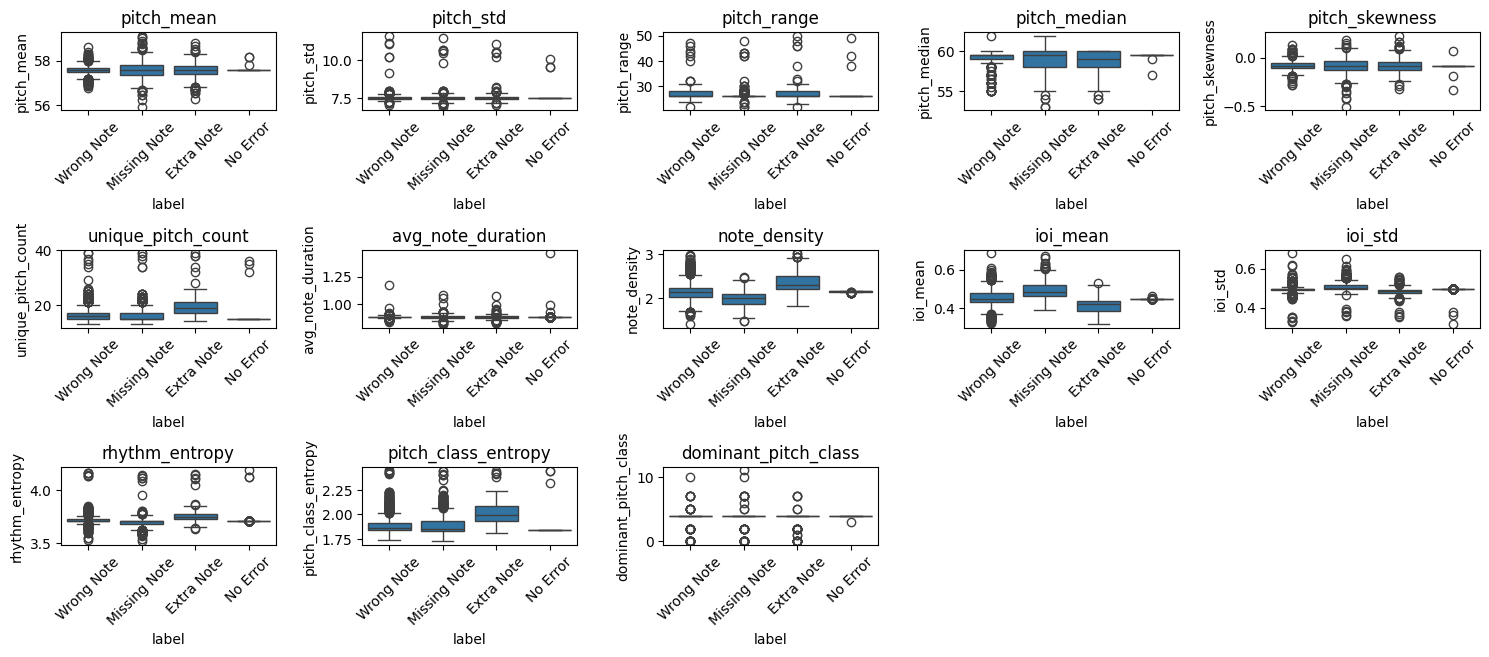

In [ ]:
diagnose_feature_distributions('/content/midi-features.csv')

In [ ]:
feat_train, _ = load_data_from_csv('midi-features.csv')
feature, _ = extract_features_single_file('/content/Twinkle_Twinkle_Little_Star_Easy.mid')
feat_predict = np.array(list(feature.values()))
compare_feature_stats(feat_train, feat_predict)

Training Features Statistics:
                 0            1            2            3            4   \
count  2020.000000  2020.000000  2020.000000  2020.000000  2020.000000   
mean     57.578143     7.527321    26.610891    58.993812    -0.081946   
std       0.279276     0.321140     2.041928     1.197379     0.060554   
min      55.940476     6.918552    22.000000    53.000000    -0.507298   
25%      57.481734     7.452671    26.000000    59.000000    -0.102489   
50%      57.581395     7.484037    26.000000    59.500000    -0.083509   
75%      57.670770     7.546748    26.000000    59.500000    -0.060413   
max      59.109890    11.612222    50.000000    62.000000     0.228021   

                5            6            7            8            9   \
count  2020.000000  2020.000000  2020.000000  2020.000000  2020.000000   
mean     17.008911     0.881557     2.162980     0.453346     0.494521   
std       3.285479     0.020579     0.235060     0.049632     0.023837   
min   

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


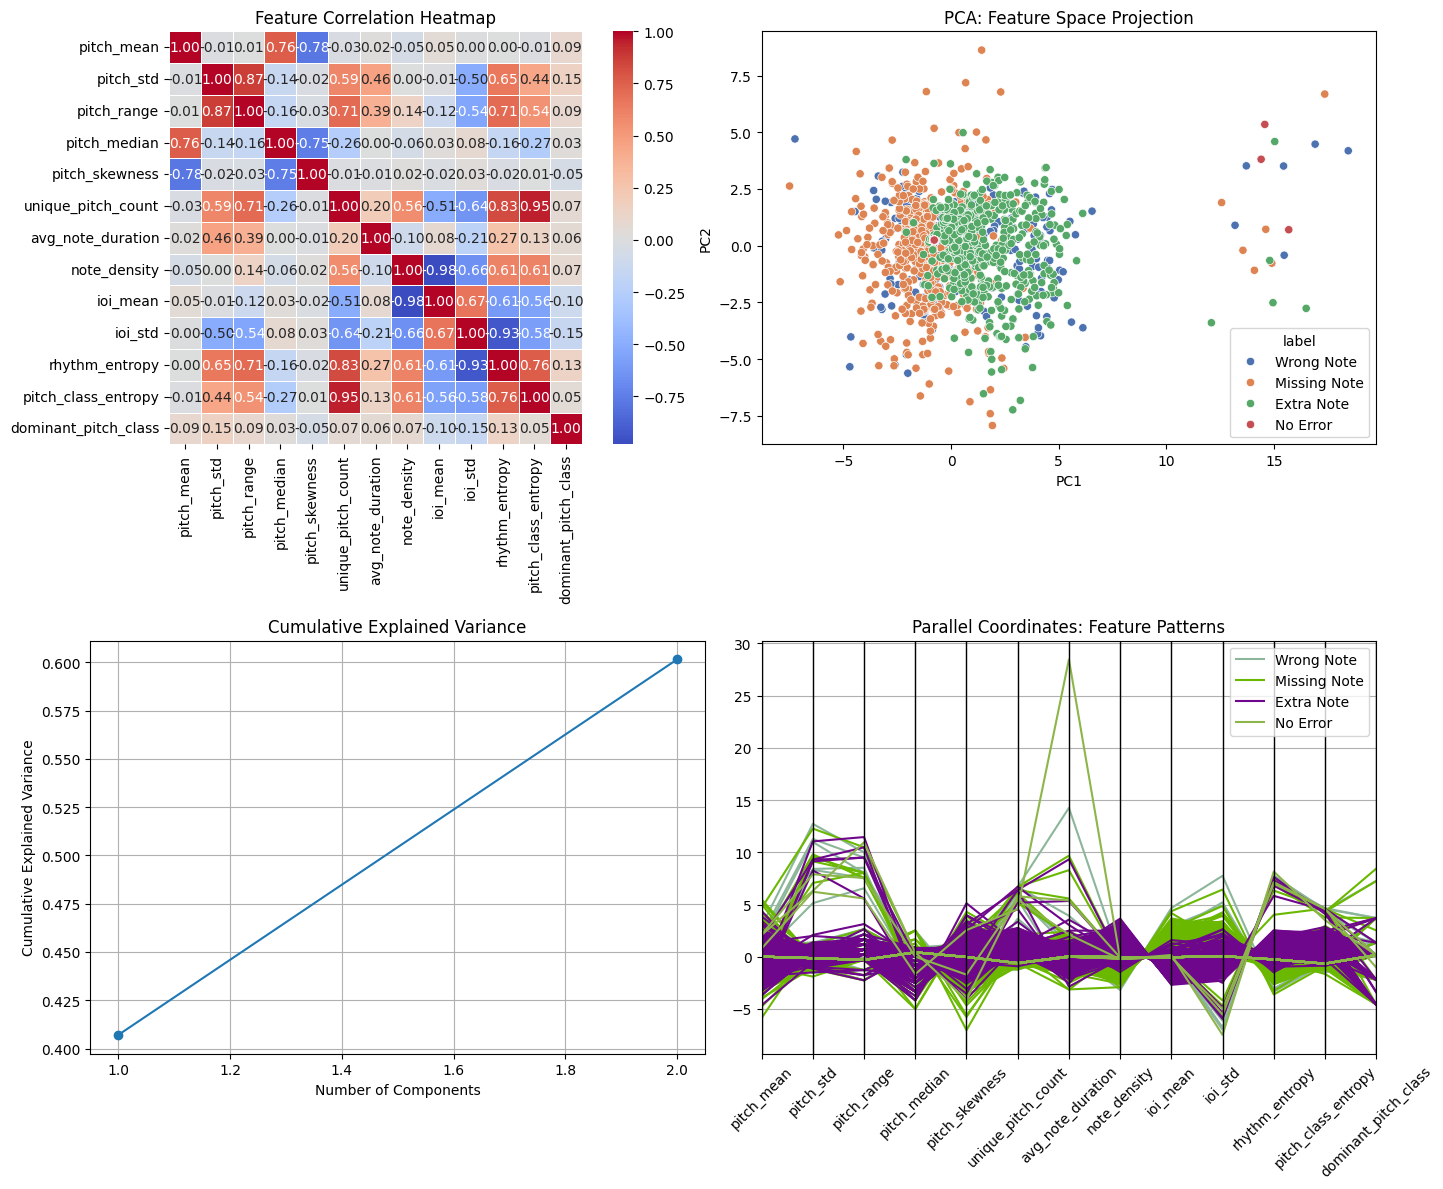

<Figure size 1200x600 with 0 Axes>

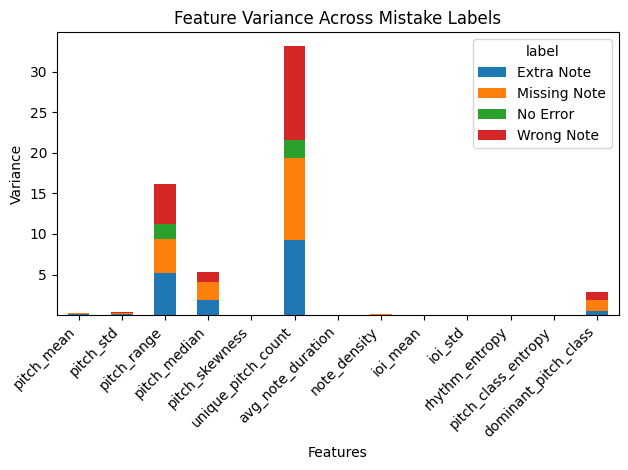

In [ ]:
def advanced_feature_analysis(csv_path):
    """EDA for MIDI features"""
    # Load data
    data = pd.read_csv(csv_path)
    features_columns = data.columns[:-1]

    # Correlation Heatmap
    plt.figure(figsize=(15, 12))
    plt.subplot(2, 2, 1)
    correlation_matrix = data[features_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", square=True)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()

    # PCA Visualization
    plt.subplot(2, 2, 2)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data[features_columns])

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features)

    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    pca_df['label'] = data['label']

    sns.scatterplot(x='PC1', y='PC2', hue='label', data=pca_df, palette='deep')
    plt.title('PCA: Feature Space Projection')

    # Explained Variance Plot
    plt.subplot(2, 2, 3)
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)

    # Parallel Coordinates Plot
    plt.subplot(2, 2, 4)
    from pandas.plotting import parallel_coordinates
    scaled_data = pd.DataFrame(scaled_features, columns=features_columns)
    scaled_data['label'] = data['label']
    parallel_coordinates(scaled_data, 'label')
    plt.title('Parallel Coordinates: Feature Patterns')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.savefig('advanced_midi_feature_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Feature importance via variance between classes
    feature_importance = {}
    for feature in features_columns:
        feature_importance[feature] = data.groupby('label')[feature].var()

    plt.figure(figsize=(12, 6))
    feature_var_df = pd.DataFrame(feature_importance).T
    feature_var_df.plot(kind='bar', stacked=True)
    plt.title('Feature Variance Across Mistake Labels')
    plt.xlabel('Features')
    plt.ylabel('Variance')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('feature_variance_by_label.png', dpi=300)
    plt.show()

    return correlation_matrix, pca, feature_importance

correlation_matrix, pca, feature_importance = advanced_feature_analysis('midi-features.csv')

In [ ]:
print("\nTop 3 Most Variant Features per Label:")
for label, variances in feature_importance.items():
    top_features = variances.nlargest(3)
    print(f"\n{label} Label:")
    print(top_features)


Top 3 Most Variant Features per Label:

pitch_mean Label:
label
Missing Note    0.147108
Extra Note      0.105089
Wrong Note      0.057837
Name: pitch_mean, dtype: float64

pitch_std Label:
label
Missing Note    0.138425
Wrong Note      0.131328
Extra Note      0.111641
Name: pitch_std, dtype: float64

pitch_range Label:
label
Extra Note      5.178823
Wrong Note      4.945239
Missing Note    4.233522
Name: pitch_range, dtype: float64

pitch_median Label:
label
Missing Note    2.275772
Extra Note      1.817268
Wrong Note      1.254903
Name: pitch_median, dtype: float64

pitch_skewness Label:
label
Missing Note    0.006905
Extra Note      0.004821
Wrong Note      0.002731
Name: pitch_skewness, dtype: float64

unique_pitch_count Label:
label
Wrong Note      11.609897
Missing Note    10.052334
Extra Note       9.298036
Name: unique_pitch_count, dtype: float64

avg_note_duration Label:
label
No Error        0.000708
Missing Note    0.000391
Extra Note      0.000316
Name: avg_note_duration,

# Model

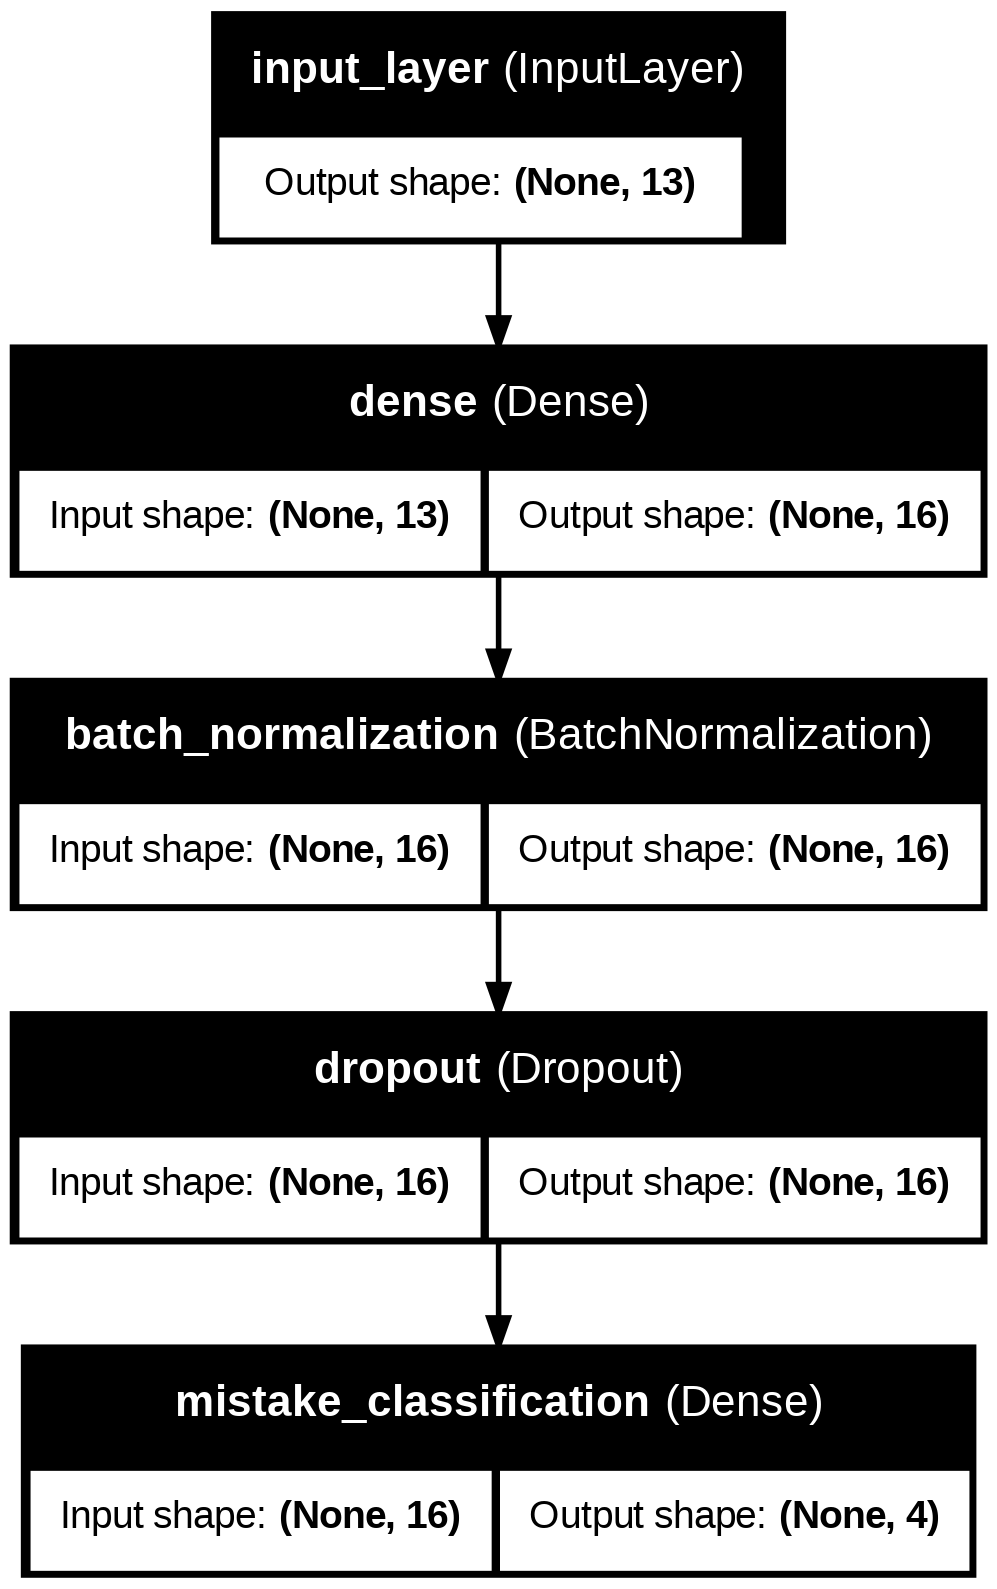

In [ ]:
def prepare_data(features, labels, test_size=0.2, val_size=0.2):
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # One-hot encode labels
    unique_labels = np.unique(labels)
    label_dict = {label: idx for idx, label in enumerate(unique_labels)}
    encoded_labels = np.array([label_dict[label] for label in labels])
    one_hot_labels = to_categorical(encoded_labels)

    # Split data
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        scaled_features,
        one_hot_labels,
        test_size=test_size,
        random_state=42,
        stratify=one_hot_labels
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val,
        y_train_val,
        test_size=val_size,
        random_state=42,
        stratify=y_train_val
    )

    return X_train, X_val, X_test, y_train, y_val, y_test, unique_labels, scaler, label_dict

def create_piano_mistake_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Dense(16, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    outputs = tf.keras.layers.Dense(
        num_classes,
        activation='softmax',
        name='mistake_classification'
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(),
                 tf.keras.metrics.Recall()]
    )
    return model

def train_model(features, labels, epochs=100, batch_size=64, test_size=0.2, val_size=0.2):
    # Prepare data
    X_train, X_val, X_test, y_train, y_val, y_test, unique_labels, scaler, label_dict = prepare_data(
        features, labels, test_size=test_size, val_size=val_size
    )

    # Create model
    model = create_piano_mistake_model(
        input_shape=(X_train.shape[1],),
        num_classes=y_train.shape[1]
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=20,
        min_lr=1e-6
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )

    model_checkpoint = ModelCheckpoint(
        'AIRA_model/v3_layer(16)/piano_mistake_model.keras',
        monitor='val_loss',
        save_best_only=True,
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        verbose=1
    )

    # Model evaluation
    test_accuracy, test_loss, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=1)
    print("Test Evaluation:")
    print("- Accuracy:", test_accuracy)
    print("- Loss:", test_loss)
    print("- Precision:", test_precision)
    print("- Recall:", test_recall)

    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Evaluation metrics
    print("\nClassification Report:")
    print(classification_report(
        y_true,
        y_pred,
        target_names=unique_labels
    ))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    os.makedirs('results', exist_ok=True)

    # Plot Training History
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(132)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Confusion Matrix Heatmap
    plt.subplot(133)
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=unique_labels,
                yticklabels=unique_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()

    plt.show()
    plt.close()

    # ROC Curve and Precision-Recall Curve
    if len(unique_labels) > 2:
        # One-vs-Rest ROC and Precision-Recall Curves
        plt.figure(figsize=(15, 5))

        # ROC Curve
        plt.subplot(121)
        for i in range(len(unique_labels)):
            y_true_binary = (y_true == i).astype(int)
            y_pred_prob = y_pred_proba[:, i]

            fpr, tpr, _ = roc_curve(y_true_binary, y_pred_prob)
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, label=f'{unique_labels[i]} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.title('ROC Curve (Multiclass)')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')

        # Precision-Recall Curve
        plt.subplot(122)
        for i in range(len(unique_labels)):
            y_true_binary = (y_true == i).astype(int)
            y_pred_prob = y_pred_proba[:, i]

            precision, recall, _ = precision_recall_curve(y_true_binary, y_pred_prob)
            pr_auc = auc(recall, precision)

            plt.plot(recall, precision, label=f'{unique_labels[i]} (AUC = {pr_auc:.2f})')

        plt.title('Precision-Recall Curve (Multiclass)')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower left')

        plt.tight_layout()
        plt.show()
        plt.close()

    return model, history, unique_labels, scaler, label_dict


plot_model(create_piano_mistake_model((13,), 4), show_shapes=True, show_layer_names=True, to_file='outer-model.png')

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.2388 - loss: 2.1484 - precision_20: 0.2162 - recall_20: 0.0936 - val_accuracy: 0.5891 - val_loss: 1.4001 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4544 - loss: 1.3915 - precision_20: 0.5471 - recall_20: 0.2368 - val_accuracy: 0.5736 - val_loss: 1.2940 - val_precision_20: 0.6522 - val_recall_20: 0.0581 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5170 - loss: 1.2335 - precision_20: 0.6395 - recall_20: 0.3645 - val_accuracy: 0.5853 - val_loss: 1.2250 - val_precision_20: 0.6875 - val_recall_20: 0.0853 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5984 - loss: 1.0299 - precision_20: 0.6976 - recall_20: 0.4567 - val_accuracy: 0.6240 - val_loss: 1.1613 - val_precision_20: 0.6857 - val_recall_20: 0.0930 - learning_rate: 0.0010
Epoch 5/20

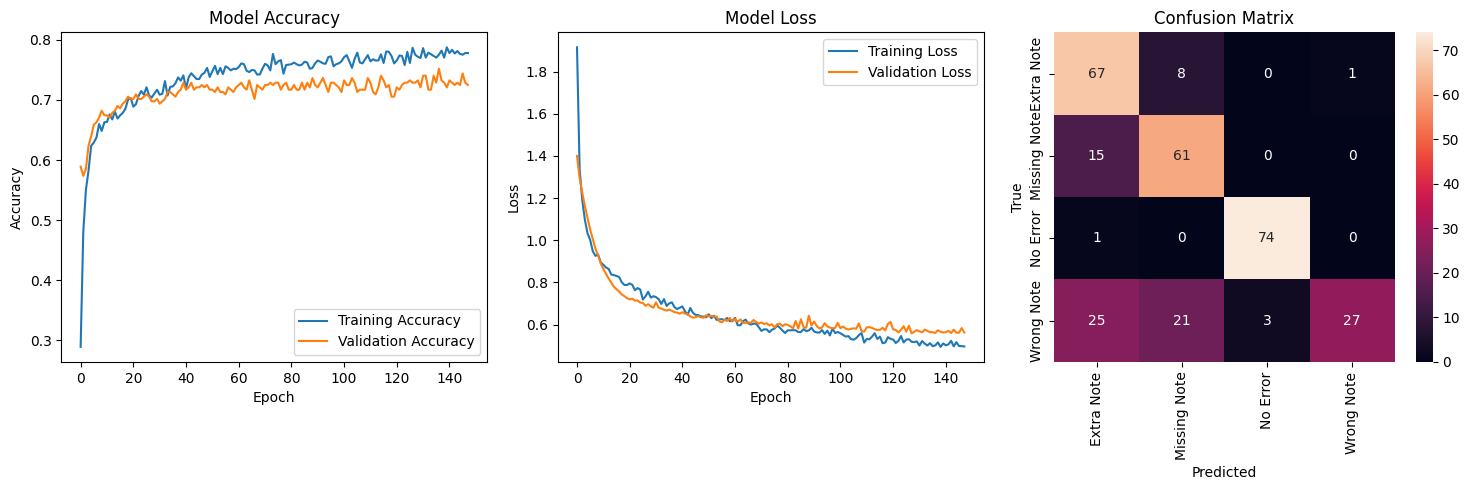

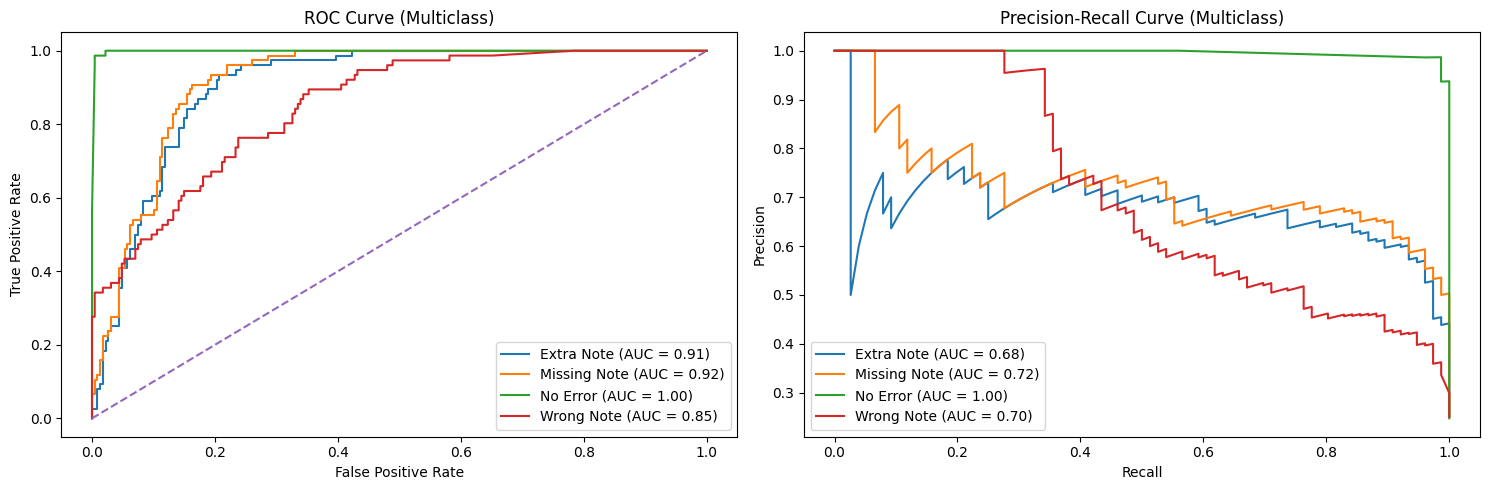

Training complete. Model and metadata saved.


In [ ]:
csv_file_path = "AIRA_dataset/midi-features.csv"
features, labels = load_data_from_csv(csv_file_path)
model, history, unique_labels, scaler, label_dict = train_model(
    features,
    labels,
    epochs=200,
    batch_size=64,
    test_size=0.15,
    val_size=0.15
)

with open('AIRA_model/v3_layer(16)/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('AIRA_model/v3_layer(16)/label_dict.pkl', 'wb') as f:
    pickle.dump(label_dict, f)

print("Training complete. Model and metadata saved.")

# Predict

In [ ]:
def load_model_and_metadata():
    model = tf.keras.models.load_model('AIRA_model/v3_layer(16)/piano_mistake_model.keras')
    with open('AIRA_model/v3_layer(16)/scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    with open('AIRA_model/v3_layer(16)/label_dict.pkl', 'rb') as f:
        label_dict = pickle.load(f)
    unique_labels = list(label_dict.keys())
    return model, scaler, unique_labels

def predict_mistake(model, features, scaler, unique_labels):
    features = np.array(list(features.values()))
    scaled_features = scaler.transform(features.reshape(1, -1))
    predictions = model.predict(scaled_features)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    return unique_labels[predicted_class_index], predictions[0]

def predict_single_file(file_path):
    new_data = extract_features_single_file(file_path)
    model, scaler, unique_labels = load_model_and_metadata()
    prediction, probabilities = predict_mistake(model, new_data, scaler, unique_labels)
    confidence = max(probabilities)

    print(f"Predicted Mistake: {prediction}")
    print("\nPrediction Probabilities:")
    for label, prob in zip(unique_labels, probabilities):
        print(f"{label}: {prob:.2%}")

    result = {
        "file_name": file_path,
        "mistake": prediction,
        "confidence": float(confidence)
    }

    return result

def predict_folder(folder_path):
    model, scaler, unique_labels = load_model_and_metadata()
    results = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.mid') or file_name.endswith('.midi'):
            file_path = os.path.join(folder_path, file_name)
            print(f"Processing file: {file_path}")

            features_dict = extract_features_single_file(file_path)
            prediction, probabilities = predict_mistake(model, features_dict, scaler, unique_labels)
            confidence = max(probabilities)

            results.append({
                "file_name": file_name,
                "mistake": prediction,
                "confidence": float(confidence)
            })

            print(f"Predicted Mistake: {prediction}")
            print("Prediction Probabilities:")
            for label, prob in zip(unique_labels, probabilities):
                print(f"  {label}: {prob:.2%}")
            print()

    return results

In [ ]:
model, scaler, unique_labels = load_model_and_metadata()

# Predict single file
result = predict_single_file('Twinkle_Twinkle_Little_Star_Easy.mid')

result_file = 'result.json'
with open(result_file, 'w') as f:
    json.dump(result, f, indent=4)

print(f"\File predictions saved to {result_file}")
print()

# Predict folder
results = predict_folder('predictions')

results_file = 'results.json'
with open(results_file, 'w') as f:
    json.dump(results, f, indent=4)

print(f"\nFolder predictions saved to {results_file}")

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted Mistake: No Error

Prediction Probabilities:
Extra Note: 0.28%
Missing Note: 0.48%
No Error: 97.42%
Wrong Note: 1.83%
\File predictions saved to result.json

Processing file: predictions/ttls_4.mid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Predicted Mistake: Wrong Note
Prediction Probabilities:
  Extra Note: 0.58%
  Missing Note: 37.45%
  No Error: 0.77%
  Wrong Note: 61.20%

Processing file: predictions/ttls_19.mid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted Mistake: Missing Note
Prediction Probabilities:
  Extra Note: 0.00%
  Missing Note: 82.49%
  No Error: 0.00%
  Wrong Note: 17.51%

Processing file: predictions/ttls 5.mid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted Mistake: No Error
Prediction Probabilities:
  Extra Note: 2.48%
  Missing Note: 0.03%
  No Error: 97.46%
  Wrong Note: 0.03%

Processing file: predictions/ttls 1.mid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Mistake: Missing Note
Prediction Probabilities:
  Ext

In [ ]:
!zip -r model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/v2_layer(128-64-16)/ (stored 0%)
  adding: content/model/v2_layer(128-64-16)/scaler.pkl (deflated 13%)
  adding: content/model/v2_layer(128-64-16)/piano_mistake_model.keras (deflated 30%)
  adding: content/model/v2_layer(128-64-16)/label_dict.pkl (deflated 20%)
  adding: content/model/v3_layer(16)/ (stored 0%)
  adding: content/model/v3_layer(16)/scaler.pkl (deflated 13%)
  adding: content/model/v3_layer(16)/piano_mistake_model.keras (deflated 79%)
  adding: content/model/v3_layer(16)/label_dict.pkl (deflated 20%)
  adding: content/model/base/ (stored 0%)
  adding: content/model/base/scaler.pkl (deflated 13%)
  adding: content/model/base/piano_mistake_model.keras (deflated 51%)
  adding: content/model/base/label_dict.pkl (deflated 20%)
